# Wordle solver - word entropy based algorithm to provide Wordle assistance and overall algorithm assessment

## Author:  DM Rosewarne.  Consultant Radiologist, HEE Topol fellow - Team AI

The sheet describes a tool for Wordle assistance which uses the revealed game state so far to narrow the range of possible word guesses.  The assistance will always suggest from the 2315 word Wordle vocabulary and will always use all the clue infomation available.  10 choices are given, ranked in order of 'word entropy' a heuristic score intended to select words that are likely to reveal useful information for future rounds (ie common letters and non-repeated letters tend to be favoured).

The following cell defines the functions we shall use, and imports from libraries:


In [5]:
from collections import Counter
import math
import re
from itertools import permutations
import matplotlib.pyplot as plt

'''
Acquire the Wordle vocabulary and strip off the newline

''' 
with open('wordleWordList.txt') as f:
    words = f.readlines()
WORDLE_WORDS = [w[:-1] for w in words]
WORDLE_VOCAB_SIZE = len(WORDLE_WORDS)


def form_letter_frequencies(wordList) :
    '''
    
    Return an array of Counter objects containing letter frequencies
    at each letter position
    
    '''
    letterConcatenations = ['', '', '', '', '']
    for p in range(5):
        for w in wordList :
            letterConcatenations[p] += w[p]
    return [Counter(letterConcatenations[p]) for p in range(5)]

LETTER_FREQUENCIES = form_letter_frequencies(WORDLE_WORDS)

def entropy(f, N) :
    '''
    Entropy associated with outcome of frequency f from N
    
    '''
    if f == 0 :
        return 0.0
    else :
        return -(f/N)*math.log(f/N)

def score_word_entropy(word, frequencies, vocabSize) :
    '''
    Entropy associated with 5 letter word taking Wordle vocabularly
    frequencies as character probability model and assuming letter 
    independence (!!).  Note the final contribution which recognises 
    different letters to be more informative than repeated letters
    
    '''
    score = 0
    for p in range(5) :
        c = word[p]
        score += entropy(frequencies[p][c], vocabSize)
    return score+math.log(len(set(permutations(word))))

def score_words(wordList) :
    '''
    Provides a dictionary of word entropies for a list of words
    
    '''
    scoreDict = {}
    for w in wordList :
        scoreDict[w] = score_word_entropy(w, LETTER_FREQUENCIES, WORDLE_VOCAB_SIZE)
    return scoreDict

def rank_words(wordList) :
    '''
    Provides a ranked list of word entropies to act as a basis for recommendation
    
    '''
    return sorted(score_words(wordList).items(), key=lambda k:k[1], reverse = True)
    
    
def implement_green (wordList, letter, position, mode=True) :
    '''
    Narrow a wordlist given a correct positional clue
    (green).  mode = False used with a yellow clue
    where this implies that although the letter is used
    it is not at the indicated position
    
    '''
    return [w for w in wordList if (w[position] == letter if mode else w[position] != letter)]

def implement_yellow (wordList, letter, position) :
    wordList = implement_green (wordList, letter, position, False)
    '''
    Narrow wordlist for yellow clue.  
    The letter is in the word but not at the current
    position
    
    '''
    return [w for w in wordList if letter in w]

def implement_black (wordList, letter) :
    '''
    Narrow wordlist for black (or grey) clue
    Letter not in word.  The case that there are
    no more of a given letter is dealth with by
    generating a new type of clue with label l
    ion functions below
    
    '''
    return[w for w in wordList if letter not in w]

def calc_letter_limit(word, feedback, position) :
    '''
    Count the occurrences of a letter that is present in 
    a word at given position
    
    '''
    char = word[position]
    count = 0
    for i in range(len(word)) :
        if (word[i] == char) and (feedback[i] == 'y' or feedback[i] == 'g') :
            count += 1
    return count

def implement_letter_limit(wordList, word, clues, position) :
    '''
    Exclude words with more occurrences of a letter than 
    indicated by the clues given
    
    '''
    char = word[position]
    l = calc_letter_limit(word, clues, position)
    return [w for w in wordList if w.count(char) <= l]


def parse_clues(word, clues) :
    '''
    Takes a clue string and replaces a "b" character
    with "l" when the "b" indicates that the letter 
    limit has been reached
    
    '''
    gyLetters = ''
    parsedClues = ''
    for i in range(len(word)) :
        if (clues[i] == 'g') or (clues [i] == 'y') :
            gyLetters += word[i]
    for i in range(len(word)) :
        if (clues[i] == 'b') and (word[i] in gyLetters) :
            parsedClues += 'l'
        else :
            parsedClues += clues[i]
    return parsedClues    

def implement_clues(wordList, word, clues) :
    '''
    Narrow a word list by information from a full
    set of clues
    
    '''
    clues = parse_clues(word, clues)
    p = 0
    for c in clues :
        if c == 'g' :
            wordList = implement_green(wordList, word[p], p)
        if c == 'y' :
            wordList = implement_yellow(wordList, word[p], p)
        if c == 'b' :
            wordList = implement_black(wordList, word[p])
        if c == 'l' :
            wordList = implement_letter_limit(wordList, word, clues, p)
        p += 1
    return wordList


def generate_clue(word, target) :
    '''
    This is used in algorithm assessment.
    It generates the feedback string for guess
    "word" against known "target" word
    
    '''
    letterCounts = Counter(target)
    feedbackString = ''
    for p in range(len(word)) :
        fb = ''
        if word[p] == target[p] :
            fb = 'g'
        elif word[p] not in target :
            fb = 'b'
        elif fb == '' and Counter(word[:p])[word[p]] < letterCounts[word[p]] :
            fb = 'y'
        else : 
            fb = 'l'
        feedbackString = feedbackString + fb
    return feedbackString
        

# Wordle assistance

The cell below provides Wordle assistance alongside an active Wordle game.  The user just needs to transcribe the clues given by the game in a format such as 'gbyyg' where g = green, b = black (sometimes rendered grey, but indicating not present or letter count reached) and y = yellow.  The suggested word can be accepted or ignored.  If ignored there is no verification that the word chosen would be accepted by Wordle - it is intended that this is verified first with the game.

In [4]:
workingList = WORDLE_WORDS
NUM_SUGGESTIONS = 10

tries = 1
endGame = False
clues = ''
while (tries <= 6) and (endGame == False):
    scoreDict = rank_words(workingList) 
    suggestions = scoreDict[:NUM_SUGGESTIONS]
    print('\n\nTry number: ', tries)
    print('Remaining Wordle words: ', len(workingList))
    print ('Top suggestions:\n', suggestions, '\n')
    validWord = False    
    while (not validWord) :
        word = input('Enter a 5 letter word or just ENTER for highest ranked choice: ').lower()
        if word == '' :
            validWord = True
            word = suggestions[0][0]
            print('Word chosen was: ', word)
        if  (not re.search('[b|y|g]{5}', word)) & (len(word) == 5) :
            validWord = True            
    validClue = False
    while (not validClue) :
        clues = input('Enter clue string in format "bgyby" etc: ')
        if re.search('[b|y|g]{5}', clues) :
            if len(clues) == 5 :
                validClue = True
    if clues == 'ggggg' :
        print ('Nice one :-)\n')
        endGame = True
    workingList = implement_clues(workingList, word, clues)
    if len(workingList) == 0 :
        print ('No possibilities remain - incorrect clue information entered somewhere :-(')
        endGame = True
    tries +=1




Try number:  1
Remaining Wordle words:  2315
Top suggestions:
 [('slate', 6.038993621880171), ('saint', 6.036189873242096), ('slice', 6.029608593304491), ('crane', 6.025661332163921), ('sauce', 6.0236523125994195), ('shale', 6.0167944136368705), ('saute', 6.0137278278904365), ('shine', 6.011309819829561), ('suite', 6.0100806229416905), ('share', 6.0094894967789045)] 

Enter a 5 letter word or just ENTER for highest ranked choice: 
Word chosen was:  slate
Enter clue string in format "bgyby" etc: dfdfdfdf
Enter clue string in format "bgyby" etc: bgggg


Try number:  2
Remaining Wordle words:  2
Top suggestions:
 [('plate', 5.9185925010788605), ('elate', 5.162164946416885)] 

Enter a 5 letter word or just ENTER for highest ranked choice: 
Word chosen was:  plate
Enter clue string in format "bgyby" etc: ggggg
Nice one :-)



# Algorithm assessment

The cell below evaluates the performance of the above algorithm over all possible Wordle target words.

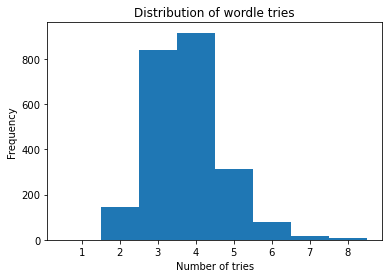

Average number of tries (all words):  3.7460043196544275
Average number of tries (successes only):  3.7107329842931938
Rate of failure to reach solution in 6 guesses (%):  0.9935205183585313


In [54]:
totalTries = 0
failCount = 0
successCount = 0
successTryCount = 0
tryList = []

for target in WORDLE_WORDS :
    workingList = WORDLE_WORDS
    tryCount = 0
    clues = ''
    while clues != 'ggggg' :
        tryCount +=1
        scoreDict = rank_words(workingList) 
        word = scoreDict[0][0]
        clues = generate_clue(word, target)
        workingList = implement_clues(workingList, word, clues)
    totalTries += tryCount
    tryList.append(tryCount)
    if tryCount > 6 :
        failCount += 1
    else :
        successCount +=1
        successTryCount += tryCount
        


plt.hist(tryList, [0.5 + w for w in range(9)])
plt.title('Distribution of wordle tries')
plt.xlabel('Number of tries')
plt.ylabel('Frequency')
plt.show()

print('Average number of tries (all words): ', totalTries/len(WORDLE_WORDS))
print('Average number of tries (successes only): ', successTryCount/successCount)
print('Rate of failure to reach solution in 6 guesses (%): ', 100*failCount/len(WORDLE_WORDS))

        

# Towards an alternative strategy

In the below we score a word by the average information revealed by the first feedback clue over the ensemble of Wordle words.  If after feedback there are N possible remaining words, the residual entropy is -log(N).  We suggest that a good starting word would be one that minimises the expectation of this quantity over the Wordle ensemble.  The scatter diagram demonstrates the correlation between this score and the word entropy score used in the assistance algorithm.

Top starting suggestions by information gain:
 [('raise', 3.6729084367414617), ('slate', 3.688250773990957), ('crate', 3.702738501542575), ('irate', 3.705148590802027), ('trace', 3.7057365643912914), ('arise', 3.7123970246417453), ('stare', 3.721865183426486), ('snare', 3.7476441413142076), ('arose', 3.749232944205809), ('least', 3.7604280036378346)] 



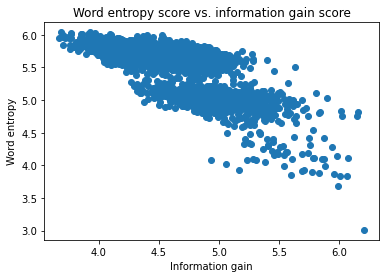

In [29]:
scoresAverageInfoGain={}

for word in WORDLE_WORDS :
    S = 0   
    for target in WORDLE_WORDS :
        clues = generate_clue(word, target)
        candidateList = implement_clues(WORDLE_WORDS, word, clues)
        S += math.log(len(candidateList))
    S = S/len(WORDLE_WORDS)
    scoresAverageInfoGain[word] = S

scoresWordEntropy = score_words(WORDLE_WORDS)


NUM_SUGGESTIONS = 10

bestStarters = sorted(scoresAverageInfoGain.items(), key=lambda k:k[1], reverse = False)[:NUM_SUGGESTIONS]
print ('Top starting suggestions by information gain:\n', bestStarters, '\n')

x = []
y = []
for w in scoresAverageInfoGain :
    x.append(scoresAverageInfoGain[w]) 
    y.append(scoresWordEntropy[w])
plt.scatter(x, y)
plt.title('Word entropy score vs. information gain score')
plt.xlabel('Information gain')
plt.ylabel('Word entropy')
plt.show()   

# Comment

There is general correlation between the two different word scores, though clearly rather imperfect.  The striking characteristic is the banded structure of word entropy - no doubt related to the contribution to the word entropy from repeated letters through the contribution from the number of letter permutations in the word (not verifed to be so, though, yet).  I have verified the outlier at bottom right 'mamma' - the candidate worst Wordle starter. 'slate' would appear to be a very good starting word - it is the only word common to both top 10's and ranks first for word entropy score and second for information gain.

The information gain strategy is too computationally intensive to provide in-game assisstance, but could in principle be extended to trying all combinations of word choices to try N, and scoring the remaining ensemble of possibilies, to see if performance better than the word entropy score can be obtained.  Alternatively, the strategy could be employed after the first try when the tree of possibilities has been narrowed dramatically.